<p> <H2> P4: Guarda se fa freddo </H2> </p>

Il dataset GlobalLandTemperaturesByMajorCity.csv riporta la temperatura registrata nelle maggiori città del mondo a partire dal 1750.
Usando questi dati, il progetto dovrà fornire una visualizzazione grafica efficace del variare delle temperature nel tempo, evidenziando le città in cui si sono registrate le maggiori escursioni termiche nei diversi periodi storici. Per la visualizzazione dei dati su mappa si veda geopandas.
Il programma inoltre dovrà suggerire, a seconda del periodo considerato, il percorso migliore da seguire per un viaggatore freddoloso che intenda spostarsi da Pechino a Los Angeles muovendosi tappa dopo tappa verso la città più calda fra le 3 a lui più vicine.

In [24]:
#importo le librerie utilizzate nel progetto
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import re
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from shapely.geometry import Point
import networkx as nx

In [25]:
df = pd.read_csv('C:/Users/Utente/Esame Python Ale/GlobalLandTemperaturesByMajorCity.csv')
#df = pd.read_csv('../input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByMajorCity.csv')

In [26]:
# rinomino alcune colonne in modo da rendere più chiaro il loro contenuto e più brevi i nomi
df = df.rename(columns={'dt':'Date', 'AverageTemperature':'AvgTemp', 'AverageTemperatureUncertainty':'AvgTempUnc'})

In [27]:
# trovo i valori nulli
df.isnull().sum(axis=0)
# elimino dal dataset le righe contenenti valori nulli
df = df.dropna(axis=0)

In [28]:
df

,Date,AvgTemp,AvgTempUnc,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W
...,...,...,...,...,...,...,...
239171,2013-04-01,12.563,1.823,Xian,China,34.56N,108.97E
239172,2013-05-01,18.979,0.807,Xian,China,34.56N,108.97E
239173,2013-06-01,23.522,0.647,Xian,China,34.56N,108.97E
239174,2013-07-01,25.251,1.042,Xian,China,34.56N,108.97E


In [29]:
# pulisco le coordinate di latinutedine e longitudine per fare in modo che contengano valori solo numerici, inizio 
# ridefinendo le due colonnne come stringhe

df['Latitude'] = df['Latitude'].astype(str)
df['Longitude'] = df['Longitude'].astype(str)

# definisco una funzione che converta le stringhe a float e renda negative le latitudini quando sono a sud (contengono la S)

def convert_latitude(x):
    num_str = re.findall(r'\d+\.\d+', x)[0]
    num = float(num_str)
    if x.endswith('S'):
        num *= -1
    return num
df['Latitude'] = df['Latitude'].apply(convert_latitude)

# definisco una funzione che converta le stringhe a float e le renda negative le longitudini quando 
# sono a ovest (contengono la W)

def convert_longitude(x):
    num_str = re.findall(r'\d+\.\d+', x)[0]
    num = float(num_str)
    if x.endswith('W'):
        num *= -1
    return num
df['Longitude'] = df['Longitude'].apply(convert_longitude)

df

,Date,AvgTemp,AvgTempUnc,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63,-3.23
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63,-3.23
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63,-3.23
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63,-3.23
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63,-3.23
...,...,...,...,...,...,...,...
239171,2013-04-01,12.563,1.823,Xian,China,34.56,108.97
239172,2013-05-01,18.979,0.807,Xian,China,34.56,108.97
239173,2013-06-01,23.522,0.647,Xian,China,34.56,108.97
239174,2013-07-01,25.251,1.042,Xian,China,34.56,108.97


In [30]:
# osservo quante città sono contemplate dal dataset per ogni anno, poiché variano nel tempo

#grouped_year = df.groupby(df.Date)['City'].nunique()
#pd.set_option('display.max_rows', 3200)
#print(grouped_year)

In [31]:
# converto il formato della colonna data 
df['Date']= pd.to_datetime(df['Date'])
df['Year']=df['Date'].dt.year
df

,Date,AvgTemp,AvgTempUnc,City,Country,Latitude,Longitude,Year
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63,-3.23,1849
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63,-3.23,1849
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63,-3.23,1849
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63,-3.23,1849
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63,-3.23,1849
...,...,...,...,...,...,...,...,...
239171,2013-04-01,12.563,1.823,Xian,China,34.56,108.97,2013
239172,2013-05-01,18.979,0.807,Xian,China,34.56,108.97,2013
239173,2013-06-01,23.522,0.647,Xian,China,34.56,108.97,2013
239174,2013-07-01,25.251,1.042,Xian,China,34.56,108.97,2013


In [32]:
# raggruppo i dati per città e decennio e calcolo la temperatura media per ciascuno

#df_groups = df.groupby(['City', df['Date'].dt.year // 10 * 10])['AvgTemp'].mean().reset_index()[['City', 'Date', 'AvgTemp']]
#print(df_groups)

In [44]:
# raggruppo i dati per città, decennio, coordinate spaziali e calcolo la temperatura media per ciascuno

start_year = 1743
df_groups = df.groupby(['City', (df['Date'].dt.year - start_year) // 5 * 5 + start_year, 'Longitude', 'Latitude'])['AvgTemp'].mean().reset_index()
df_groups

,City,Date,Longitude,Latitude,AvgTemp
0,Abidjan,1848,-3.23,5.63,25.591056
1,Abidjan,1853,-3.23,5.63,25.560235
2,Abidjan,1858,-3.23,5.63,25.553691
3,Abidjan,1873,-3.23,5.63,25.496545
4,Abidjan,1878,-3.23,5.63,25.795183
...,...,...,...,...,...
4019,Xian,1993,108.97,34.56,11.885950
4020,Xian,1998,108.97,34.56,12.585433
4021,Xian,2003,108.97,34.56,12.478400
4022,Xian,2008,108.97,34.56,12.244050


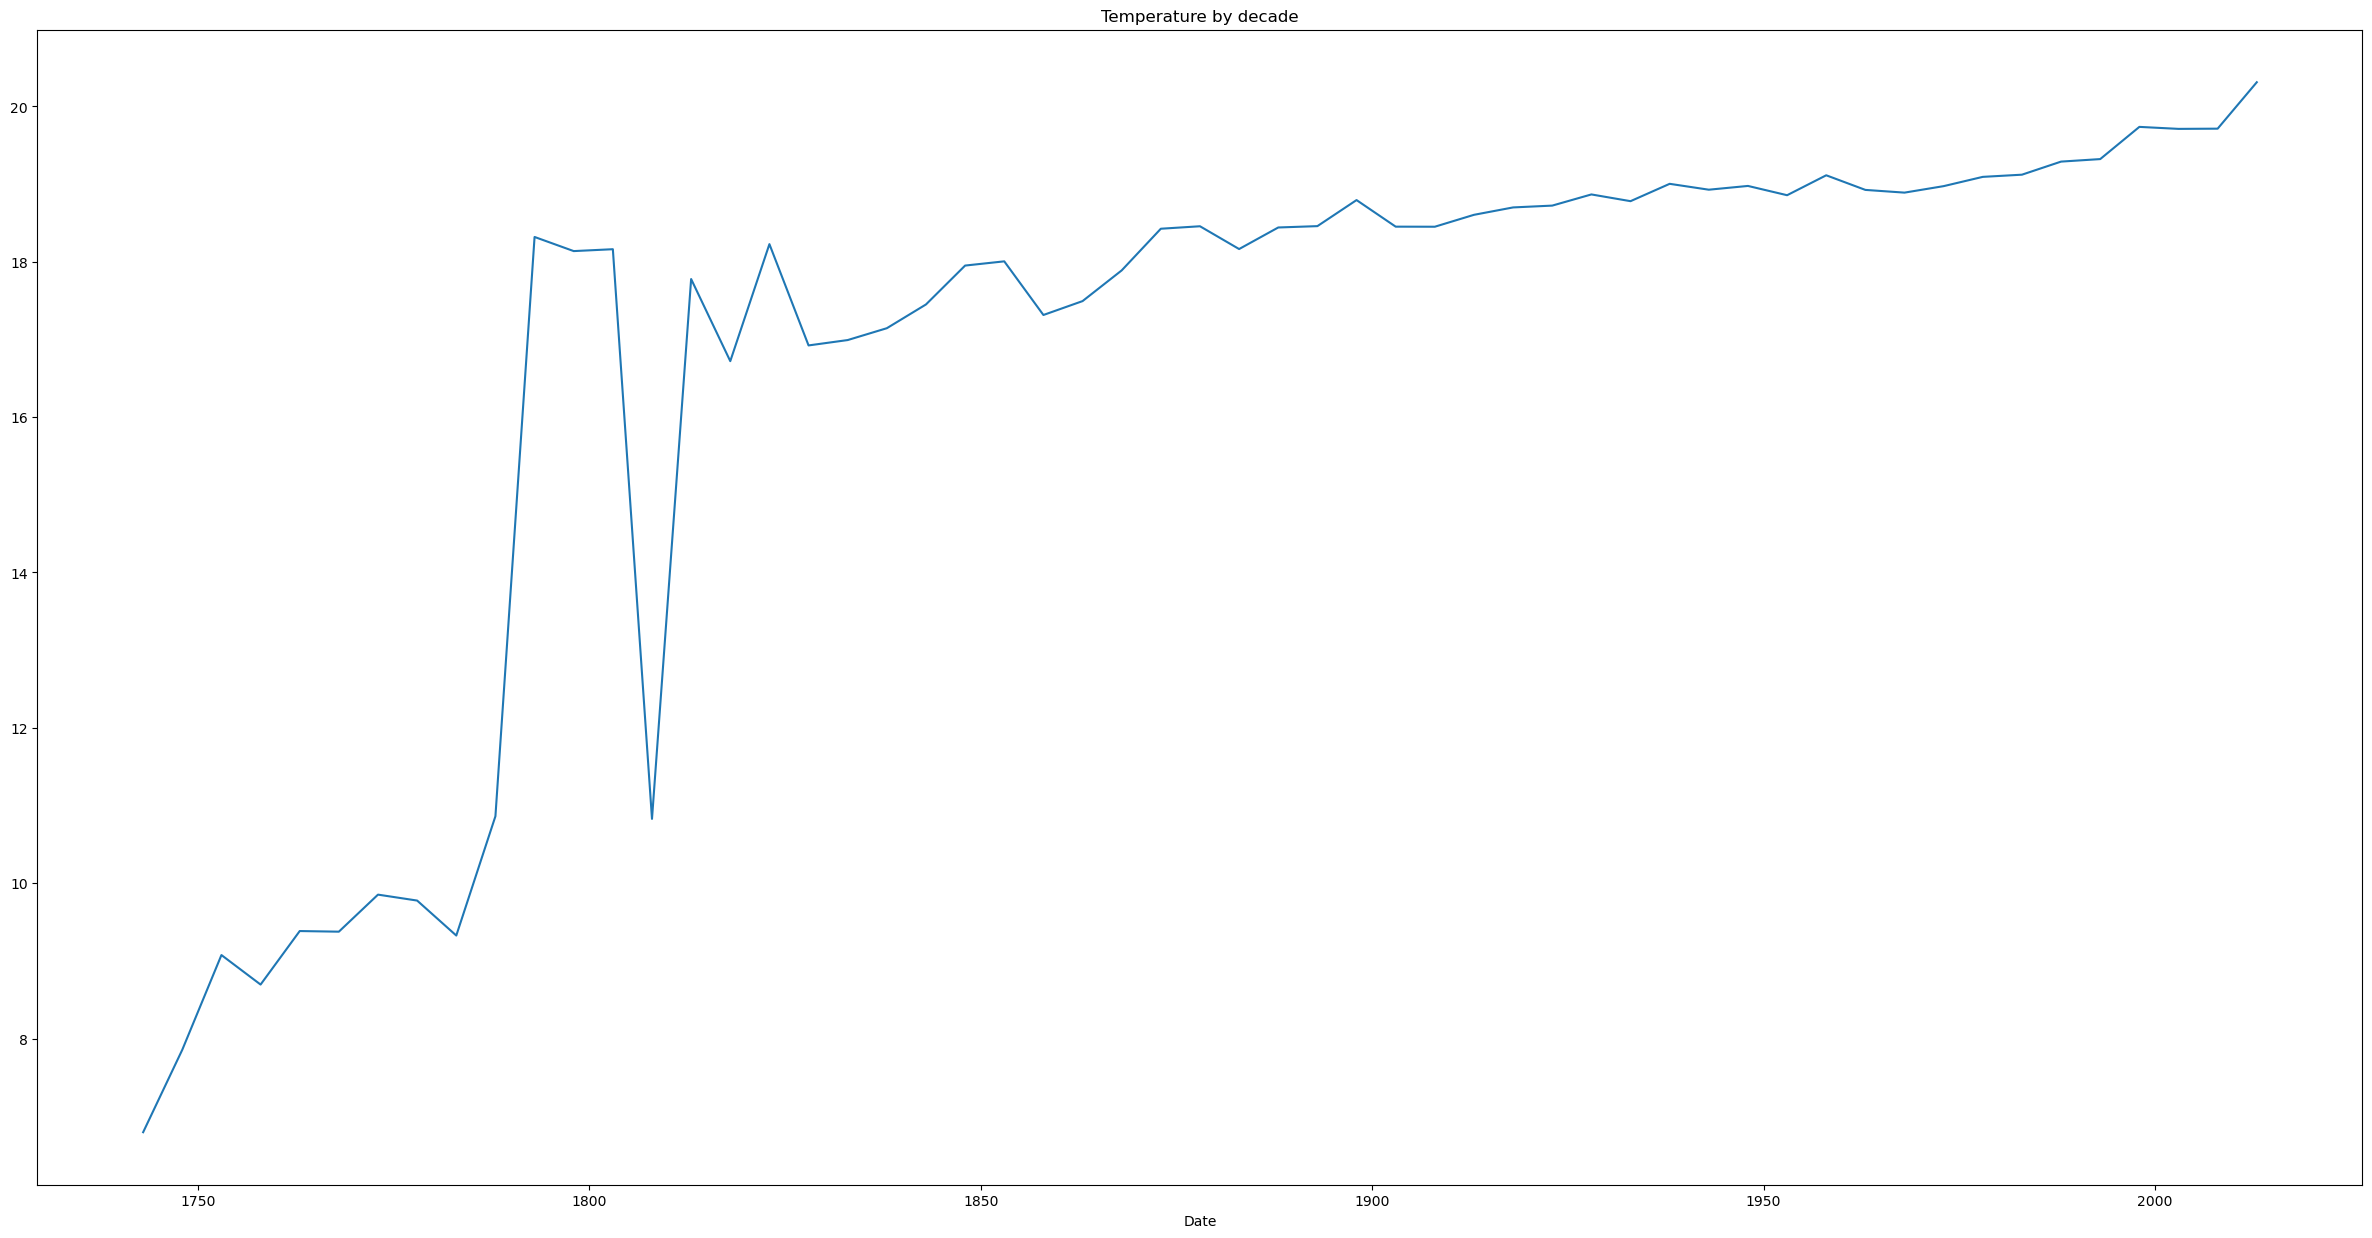

In [34]:
#plotto i dati

df_groups.groupby(df_groups.Date)['AvgTemp'].mean().plot(figsize=(30,15), title="Temperature by decade")
plt.show()

In [35]:
# Solo per osservare cosa succede della seconda metà del 1700, raggruppo i dati per città ed estraggo l'anno di 
# introduzine nel dataset di ciascuna città

first_year_by_city = df.groupby('City')['Date'].agg(lambda x: x.min().year)
first_year_by_city = first_year_by_city.sort_values()
pd.set_option('display.max_rows', 100)
print(first_year_by_city)

# fra il 1796 e i primi anni del 1800 si inseriscono numerose città calde che incidono sulla AvgTemp

City
New York            1743
Chicago             1743
Paris               1743
Madrid              1743
London              1743
Montreal            1743
Berlin              1743
Saint Petersburg    1743
Rome                1743
Kiev                1743
Istanbul            1743
Toronto             1743
Moscow              1743
Izmir               1753
Ankara              1755
Casablanca          1763
Alexandria          1791
Aleppo              1791
Surat               1796
Lakhnau             1796
Madras              1796
Dhaka               1796
Delhi               1796
Hyderabad           1796
Jaipur              1796
New Delhi           1796
Ahmadabad           1796
Bangalore           1796
Bombay              1796
Nagpur              1796
Rangoon             1796
Pune                1796
Karachi             1796
Calcutta            1796
Kanpur              1796
Gizeh               1808
Cairo               1808
Faisalabad          1816
Lahore              1816
Bangkok             

In [47]:
# osservo l'escursione termica di ogni decade rispetto alla precedente e alla successiva 

df_groups['temp_diff_prev'] = df_groups.groupby('City')['AvgTemp'].diff()
df_groups['temp_diff_next'] = df_groups.groupby('City')['AvgTemp'].diff(-1)

In [49]:
# tengo solo le 10 maggiori escursioni osservate in ogni città 

df_excursions = df_groups.groupby('City').apply(
    lambda x: x.nlargest(5, ['temp_diff_prev', 'temp_diff_next'])
)


df_excursions = df_excursions.dropna(axis=0)
print(df_excursions)

                 City  Date  Longitude  Latitude    AvgTemp  temp_diff_prev  \
City                                                                          
Abidjan 8     Abidjan  1898      -3.23      5.63  25.912217        0.568633   
        11    Abidjan  1913      -3.23      5.63  26.299083        0.519733   
        7     Abidjan  1893      -3.23      5.63  25.343583        0.303233   
        4     Abidjan  1878      -3.23      5.63  25.795183        0.298638   
        25    Abidjan  1983      -3.23      5.63  26.641800        0.262800   
...               ...   ...        ...       ...        ...             ...   
Wuhan   3955    Wuhan  1868     114.46     29.74  16.898200        0.501700   
Xian    3987     Xian  1833     108.97     34.56  21.187333        9.427515   
        3986     Xian  1823     108.97     34.56  11.759818        0.892439   
        4020     Xian  1998     108.97     34.56  12.585433        0.699483   
        4008     Xian  1938     108.97     34.56  12

In [50]:
# conto le maggiori escursioni termiche registrate per ogni anno, prendendo i 20 anni più ricorrenti

counts = df_excursions['Date'].value_counts().reset_index().rename(columns={'index': 'Date', 'Date': 'Count'})
top20 = counts.nlargest(20, 'Count')
print(top20)

    Date  Count
0   1998     44
1   1898     35
2   1938     33
3   1888     27
4   1823     27
5   1958     24
6   1863     18
7   1868     16
8   1978     15
9   1988     15
10  1843     15
11  1818     15
12  1893     15
13  1928     12
14  1983     12
15  1748     11
16  1878     10
17  1913     10
18  1993      8
19  1858      7


<Figure size 600x400 with 0 Axes>

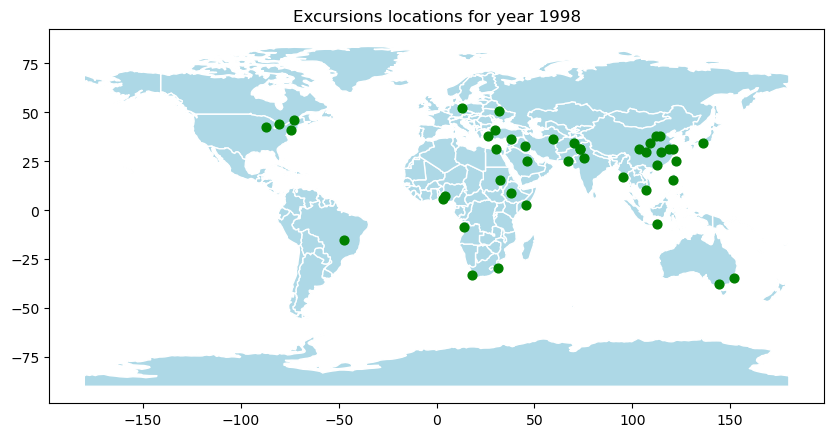

<Figure size 600x400 with 0 Axes>

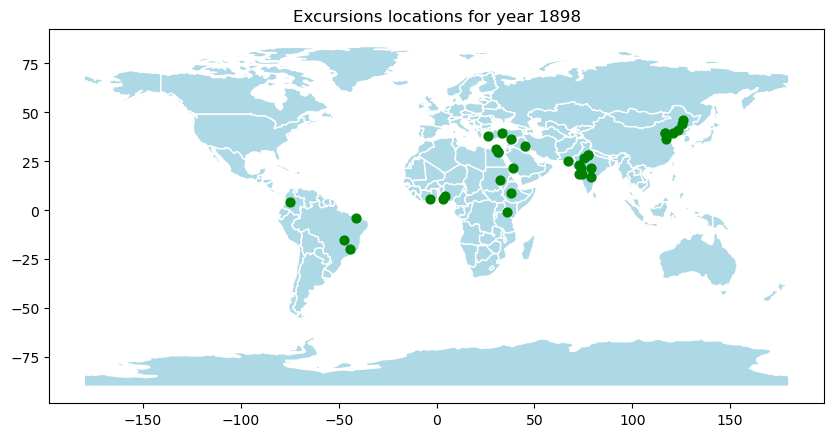

<Figure size 600x400 with 0 Axes>

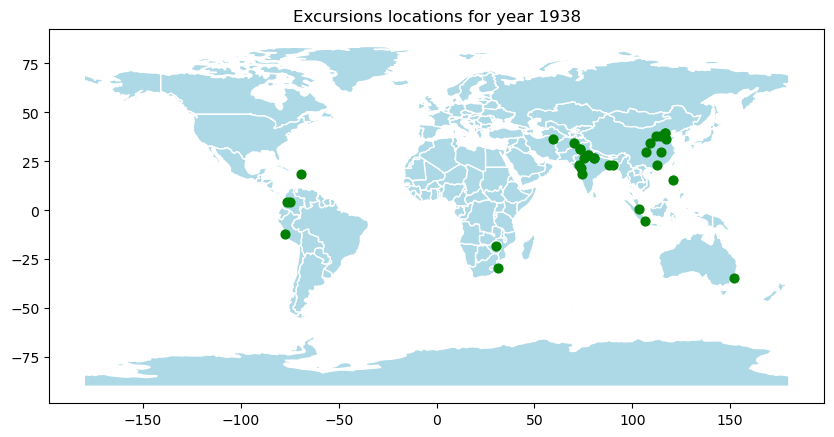

<Figure size 600x400 with 0 Axes>

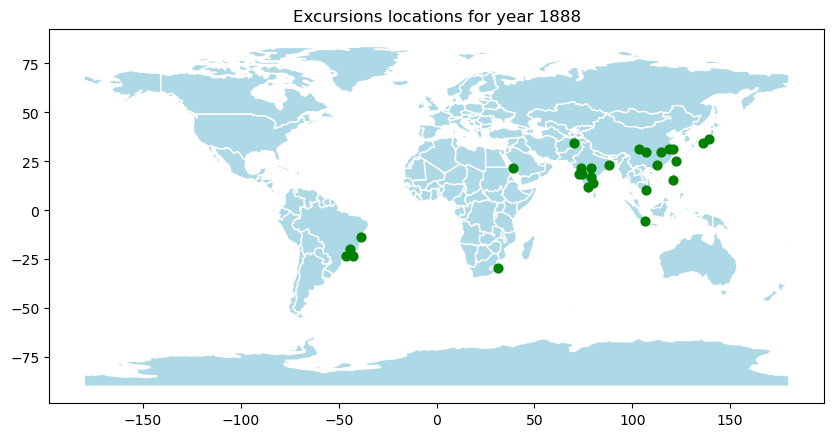

<Figure size 600x400 with 0 Axes>

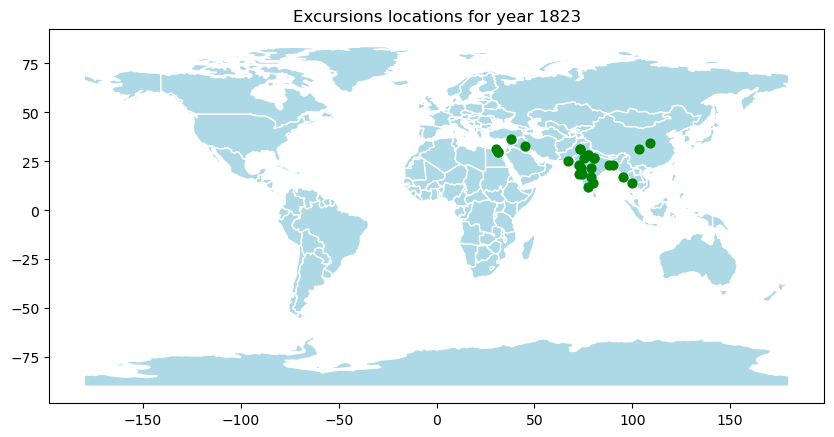

<Figure size 600x400 with 0 Axes>

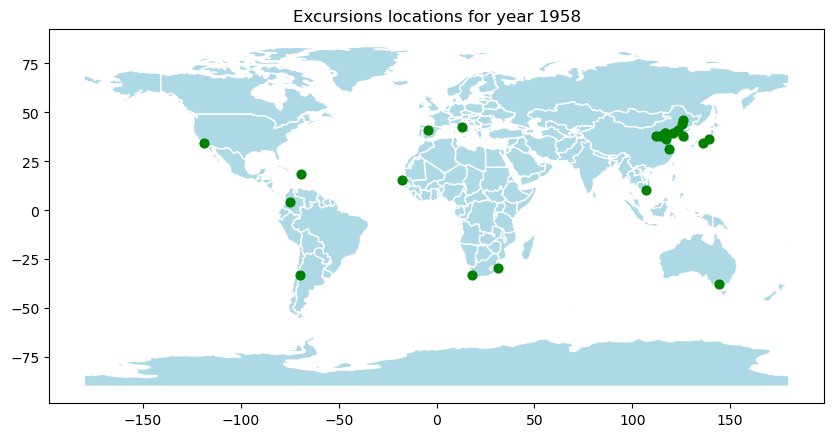

<Figure size 600x400 with 0 Axes>

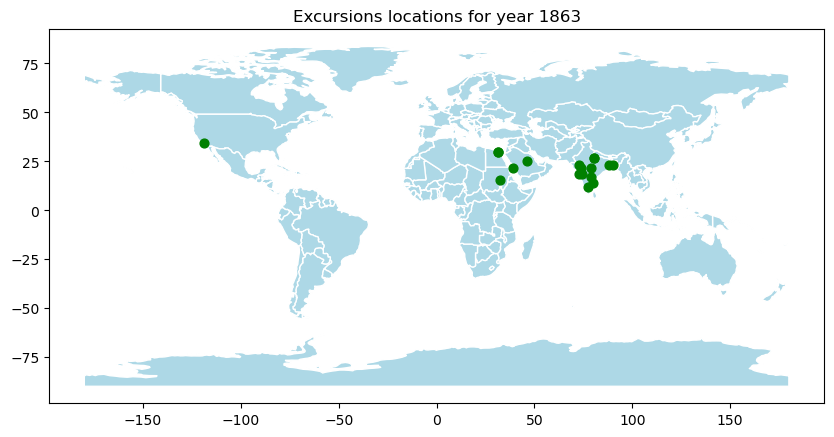

<Figure size 600x400 with 0 Axes>

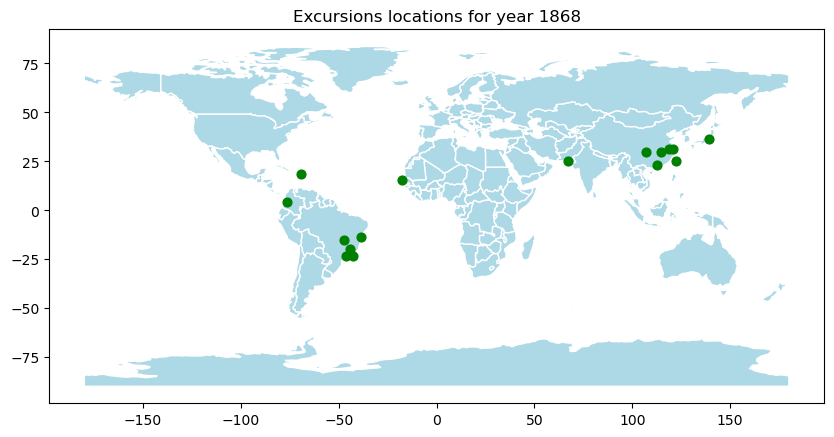

<Figure size 600x400 with 0 Axes>

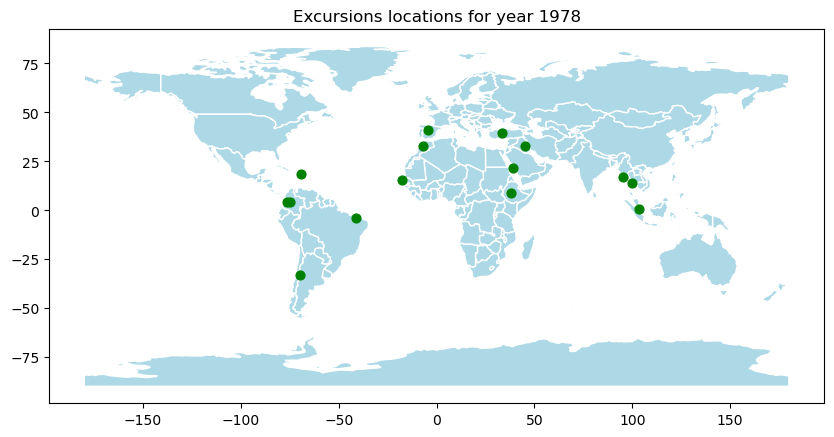

<Figure size 600x400 with 0 Axes>

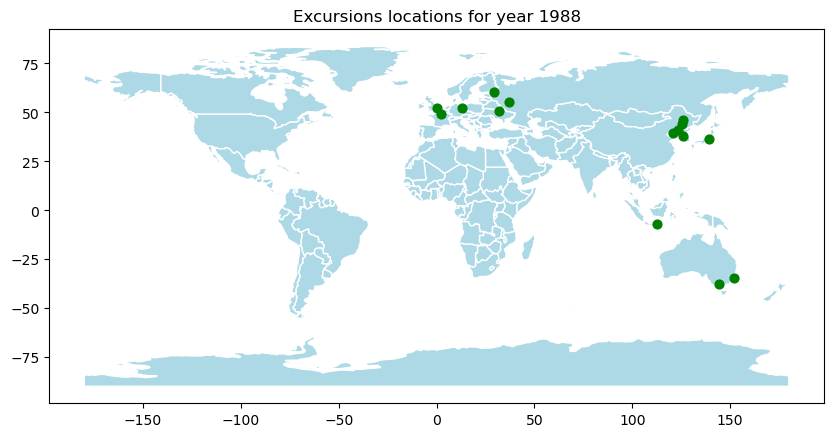

<Figure size 600x400 with 0 Axes>

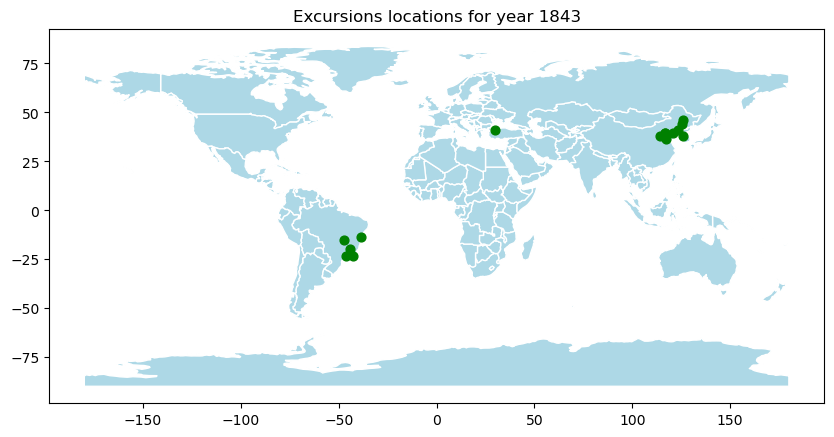

<Figure size 600x400 with 0 Axes>

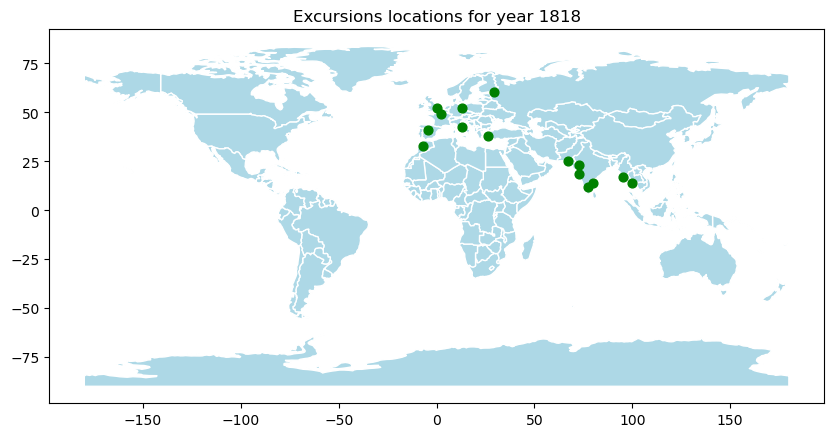

<Figure size 600x400 with 0 Axes>

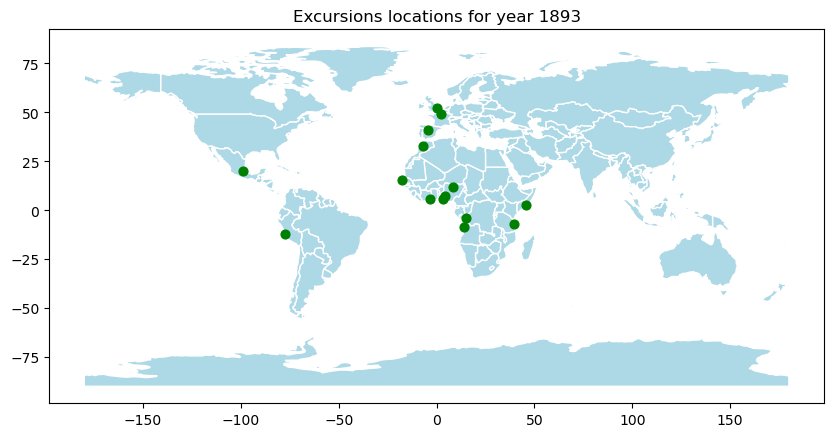

<Figure size 600x400 with 0 Axes>

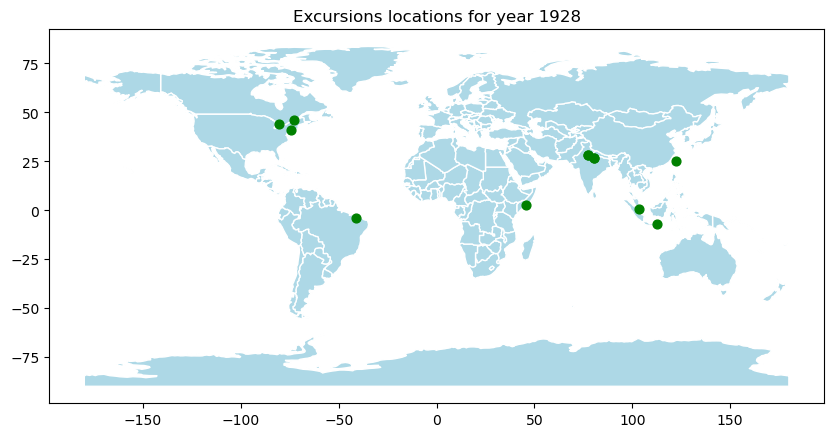

<Figure size 600x400 with 0 Axes>

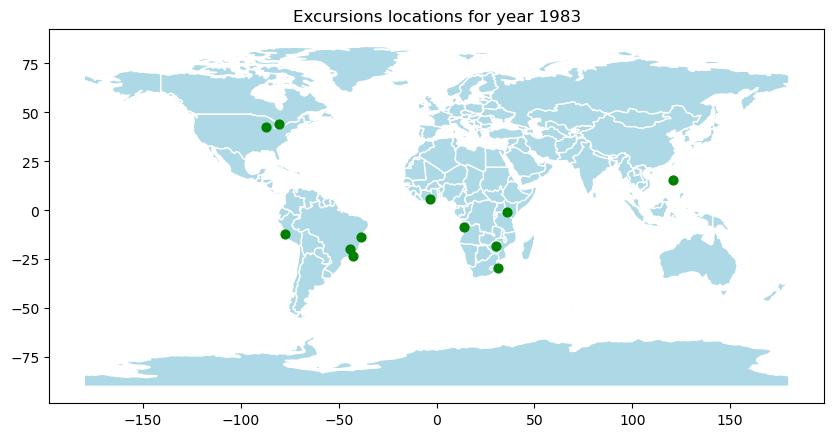

<Figure size 600x400 with 0 Axes>

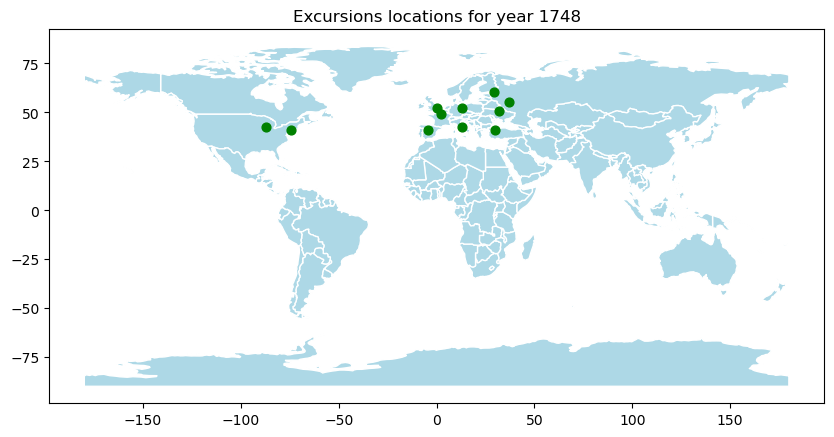

<Figure size 600x400 with 0 Axes>

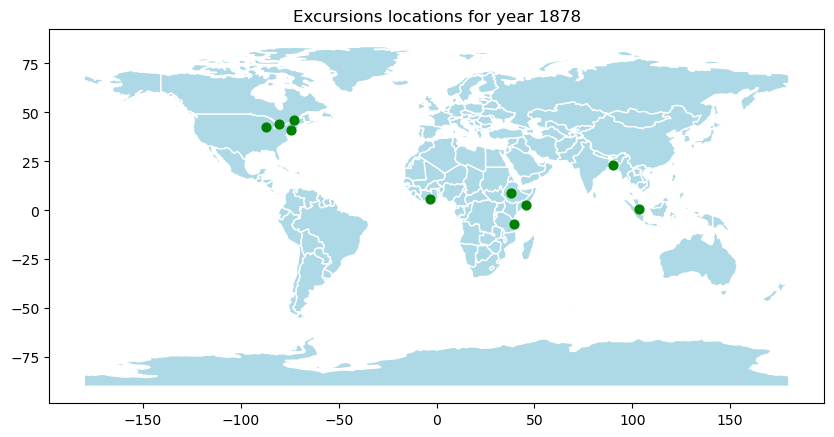

<Figure size 600x400 with 0 Axes>

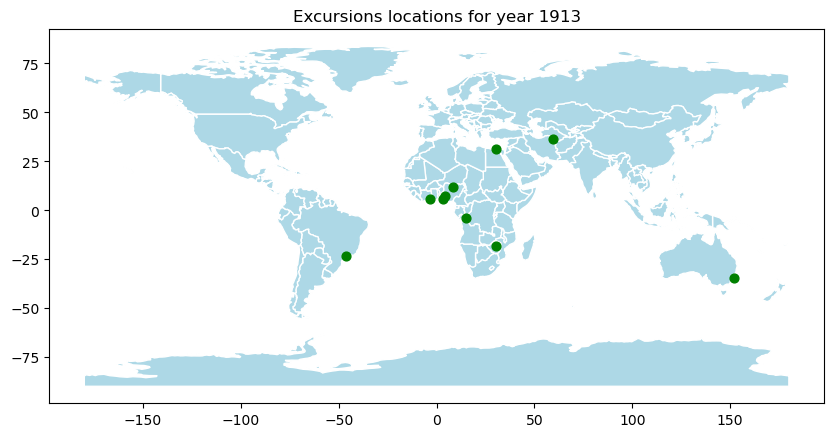

<Figure size 600x400 with 0 Axes>

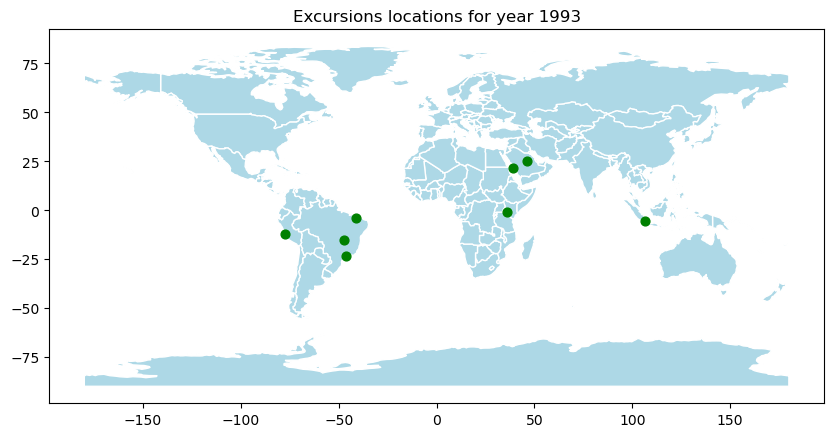

<Figure size 600x400 with 0 Axes>

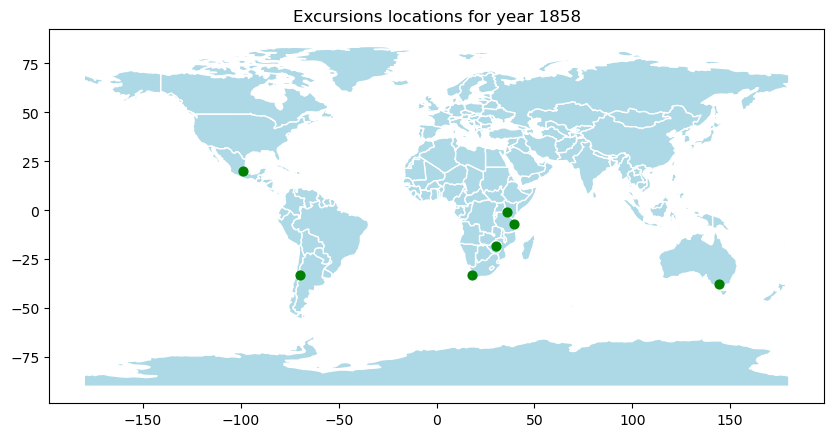

In [71]:
# inserisco in un ciclo le date ricorrenti e plotto le città con maggiori escursioni termiche nei diversi periodi
for index, row in top20.iterrows():
    year = row['Date']
    plt.figure(figsize=(6, 4))
    plot_excursions_for_year(df_excursions, year)
    #plt.title(f"Excursions for {year}")
    plt.show()

SECONDA PARTE

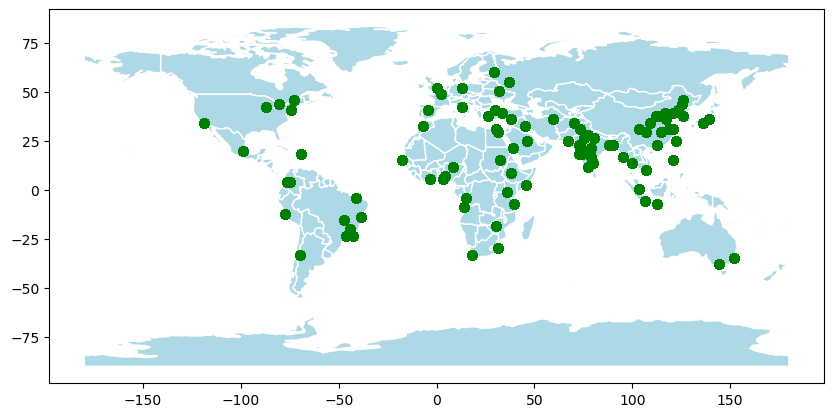

In [74]:
# plotto una mappa contenente i punti di tutti e 100 i paesi considerati dal Geodataframe

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.plot(figsize=(10, 6), edgecolor='white', facecolor='lightblue')
gdf.plot(ax=ax, color='green', markersize=40)

plt.show()

In [45]:
gdf

,Date,AvgTemp,AvgTempUnc,City,Country,Latitude,Longitude,Year,geometry
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63,-3.23,1849,POINT (-3.23000 5.63000)
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63,-3.23,1849,POINT (-3.23000 5.63000)
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63,-3.23,1849,POINT (-3.23000 5.63000)
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63,-3.23,1849,POINT (-3.23000 5.63000)
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63,-3.23,1849,POINT (-3.23000 5.63000)
...,...,...,...,...,...,...,...,...,...
239171,2013-04-01,12.563,1.823,Xian,China,34.56,108.97,2013,POINT (108.97000 34.56000)
239172,2013-05-01,18.979,0.807,Xian,China,34.56,108.97,2013,POINT (108.97000 34.56000)
239173,2013-06-01,23.522,0.647,Xian,China,34.56,108.97,2013,POINT (108.97000 34.56000)
239174,2013-07-01,25.251,1.042,Xian,China,34.56,108.97,2013,POINT (108.97000 34.56000)


In [106]:
# definisco una funzione che inserendo una città di partenza, una di destinazione, l'anno e il geodataset restituisce 
# il percorso passando dalle città più calde

def find_hottest_path(start_city, dest_city, year, gdf):
    # Filter the temperature data for the year of interest
    gdf_year = gdf[gdf['Year'] == year]
    
    # Get the temperature data for the starting city
    start_data = gdf_year[gdf_year['City'] == start_city]
    start_temp = start_data['AvgTemp'].iloc[0]
    
    # Initialize the nearest cities list
    nearest_cities = []
    
    # Initialize the current city as the starting city
    curr_city = start_city
    
    while curr_city != dest_city:
        # Get the geometry of the current city
        curr_geom = gdf.loc[gdf['City'] == curr_city, 'geometry'].iloc[0]
        print(curr_geom)
        
        # Compute the distance between the current city and all other cities
        gdf['distance'] = gdf.geometry.distance(curr_geom)
        
        # Filter the remaining cities to only include those to the west
        remaining_cities = gdf[gdf['Longitude'] < gdf.loc[gdf['City'] == curr_city, 'Longitude'].iloc[0]]
        
        # Sort the remaining cities by distance
        sorted_cities = remaining_cities.sort_values('distance')
        
        # Select the nearest city that has not been selected before
        nearest_city = sorted_cities[~sorted_cities['City'].isin(nearest_cities + [curr_city])].iloc[0]['City']
        
        # Add the nearest city to the list of nearest cities
        nearest_cities.append(nearest_city)
        
        # Update the current city
        curr_city = nearest_city
    
    # Return the list of selected cities
    return nearest_cities


In [114]:
path = find_hottest_path('Peking', 'Los Angeles', 2000, gdf)
path

['Tangshan',
 'Taiyuan',
 'Xian',
 'Chongqing',
 'Chengdu',
 'Dhaka',
 'Calcutta',
 'Kanpur',
 'New Delhi',
 'Jaipur',
 'Ahmadabad',
 'Karachi',
 'Mashhad',
 'Baghdad',
 'Aleppo',
 'Ankara',
 'Istanbul',
 'Izmir',
 'Rome',
 'Paris',
 'London',
 'Madrid',
 'Casablanca',
 'Dakar',
 'Fortaleza',
 'Brasília',
 'Santiago',
 'Lima',
 'Mexico',
 'Los Angeles']

In [109]:
def plot_cities_on_map(city_list, gdf):
    # Filter the GeoDataFrame to only include the cities in the city_list
    filtered_gdf = gdf[gdf['City'].isin(city_list)]

    # Plot the cities on a map
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(figsize=(10, 8), edgecolor='white', facecolor='lightblue')
    filtered_gdf.plot(ax=ax, color='green', markersize=40)
    plt.title('Path')
    plt.show()
    

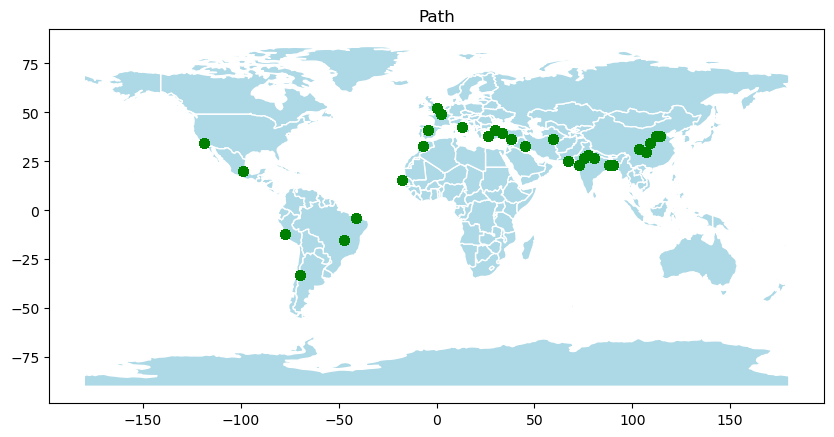

In [110]:
plot_cities_on_map(path, gdf)

In [111]:
def find_hottest_path(start_city, dest_city, year, gdf):
    # Filter the temperature data for the year of interest
    gdf_year = gdf[gdf['Year'] == year]
    
    # Get the temperature data for the starting city
    start_data = gdf_year[gdf_year['City'] == start_city]
    start_temp = start_data['AvgTemp'].iloc[0]
    
    # Initialize the nearest cities list
    nearest_cities = []
    
    # Initialize the current city as the starting city
    curr_city = start_city
    
    while curr_city != dest_city:
        # Get the geometry of the current city
        curr_geom = gdf.loc[gdf['City'] == curr_city, 'geometry'].iloc[0]
        
        # Compute the distance between the current city and all other cities
        gdf['distance'] = gdf.geometry.distance(curr_geom)
        
        # Filter the remaining cities to only include those to the west
        remaining_cities = gdf[gdf['Longitude'] < gdf.loc[gdf['City'] == curr_city, 'Longitude'].iloc[0]]
        
        # Sort the remaining cities by distance
        sorted_cities = remaining_cities.sort_values('distance')
        
        # Select the three nearest cities that have not been selected before
        nearest_cities_temp = []
        for nearest_city in sorted_cities[~sorted_cities['City'].isin(nearest_cities + [curr_city])]['City'][:3]:
            # Get the temperature data for the nearest city
            nearest_data = gdf_year[gdf_year['City'] == nearest_city]
            nearest_temp = nearest_data['AvgTemp'].iloc[0]
            
            # Add the nearest city and its temperature to the list of nearest cities
            nearest_cities_temp.append((nearest_city, nearest_temp))
        
        # Select the city with the highest temperature among the three nearest cities
        selected_city = max(nearest_cities_temp, key=lambda x: x[1])[0]
        
        # Add the selected city to the list of nearest cities
        nearest_cities.append(selected_city)
        
        # Update the current city
        curr_city = selected_city
    
    # Return the list of selected cities
    return nearest_cities


In [113]:
path = find_hottest_path('Peking', 'Los Angeles', 2000, gdf)
path

['Tangshan',
 'Taiyuan',
 'Xian',
 'Chongqing',
 'Chengdu',
 'Dhaka',
 'Calcutta',
 'Kanpur',
 'New Delhi',
 'Jaipur',
 'Ahmadabad',
 'Karachi',
 'Mashhad',
 'Baghdad',
 'Aleppo',
 'Ankara',
 'Istanbul',
 'Izmir',
 'Rome',
 'Paris',
 'London',
 'Madrid',
 'Casablanca',
 'Dakar',
 'Fortaleza',
 'Brasília',
 'Santiago',
 'Lima',
 'Mexico',
 'Los Angeles']

In [77]:
def find_hottest_path(start_city, dest_city, year, gdf):
    # Filter the temperature data for the year of interest
    gdf_year = gdf[gdf['Year'] == year]
    
    # Get the temperature data for the starting city
    start_data = gdf_year[gdf_year['City'] == start_city]
    start_temp = start_data['AvgTemp'].iloc[0]
    
    # Get the geometry of the starting and destination cities
    start_geom = gdf.loc[gdf['City'] == start_city, 'geometry'].iloc[0]
    dest_geom = gdf.loc[gdf['City'] == dest_city, 'geometry'].iloc[0]
    
    # Determine the direction of travel (east to west or west to east)
    direction = 'west' if start_geom.x > dest_geom.x else 'east'
    
    # Initialize the nearest cities list
    nearest_cities = []
    
    # Initialize the current city as the starting city
    curr_city = start_city
    
    while curr_city != dest_city:
        # Get the geometry of the current city
        curr_geom = gdf.loc[gdf['City'] == curr_city, 'geometry'].iloc[0]
        
        # Compute the distance between the current city and all other cities
        gdf['distance'] = gdf.geometry.distance(curr_geom)
        
        if direction == 'east':
            # Filter the remaining cities to only include those to the east
            remaining_cities = gdf[gdf['Longitude'] > gdf.loc[gdf['City'] == curr_city, 'Longitude'].iloc[0]]
        else:
            # Filter the remaining cities to only include those to the west
            remaining_cities = gdf[gdf['Longitude'] < gdf.loc[gdf['City'] == curr_city, 'Longitude'].iloc[0]]
        
        # Sort the remaining cities by distance
        sorted_cities = remaining_cities.sort_values('distance')
        
        # Select the nearest city that has not been selected before
        nearest_city = sorted_cities[~sorted_cities['City'].isin(nearest_cities + [curr_city])].iloc[0]['City']
        
        # Add the nearest city to the list of nearest cities
        nearest_cities.append(nearest_city)
        
        # Update the current city
        curr_city = nearest_city
    
    # Return the list of selected cities
    return nearest_cities


In [78]:
find_hottest_path('Los Angeles', 'Peking', 2000, gdf)

IndexError: single positional indexer is out-of-bounds

In [81]:
def find_hottest_path(start_city, dest_city, year, gdf):
    # Filter the temperature data for the year of interest
    gdf_year = gdf[gdf['Year'] == year]
    
    # Get the temperature data for the starting city
    start_data = gdf_year[gdf_year['City'] == start_city]
    start_temp = start_data['AvgTemp'].iloc[0]
    
    # Initialize the nearest cities list
    nearest_cities = []
    
    # Initialize the current city as the starting city
    curr_city = start_city
    
    while curr_city != dest_city:
        # Get the geometry of the current city
        curr_geom = gdf.loc[gdf['City'] == curr_city, 'geometry'].iloc[0]
        
        # Compute the distance between the current city and all other cities
        gdf['distance'] = gdf.geometry.distance(curr_geom)
        
        # Filter the remaining cities to only include those to the west or east
        remaining_cities = gdf[(gdf['Longitude'] < gdf.loc[gdf['City'] == curr_city, 'Longitude'].iloc[0]) 
                               if curr_city != dest_city else (gdf['Longitude'] > gdf.loc[gdf['City'] == curr_city, 
                                                                                          'Longitude'].iloc[0])]
        
        if len(remaining_cities) == 0:
            print(f"Sorry, there are no more cities to move to.")
            break
        
        # Sort the remaining cities by distance
        sorted_cities = remaining_cities.sort_values('distance')
        
        # Select the nearest city that has not been selected before
        nearest_city = sorted_cities[~sorted_cities['City'].isin(nearest_cities + [curr_city])].iloc[0]['City']
        
        # Add the nearest city to the list of nearest cities
        nearest_cities.append(nearest_city)
        
        # Update the current city
        curr_city = nearest_city
    
    # Return the list of selected cities
    return nearest_cities


In [88]:
path=find_hottest_path('Rome', 'Peking', 1987, gdf)

Sorry, there are no more cities to move to.


In [84]:
def plot_cities_on_map(city_list, gdf):
    # Filter the GeoDataFrame to only include the cities in the city_list
    filtered_gdf = gdf[gdf['City'].isin(city_list)]

    # Plot the cities on a map
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(figsize=(10, 8), edgecolor='white', facecolor='lightblue')
    filtered_gdf.plot(ax=ax, color='green', markersize=40)
   # world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    #ax = world.plot(figsize=(10, 6), edgecolor='black', facecolor='green')
    #filtered_gdf.plot(ax=ax, color='red', markersize=50)

    # Set the title and show the plot
    plt.title('Path')
    plt.show()
    

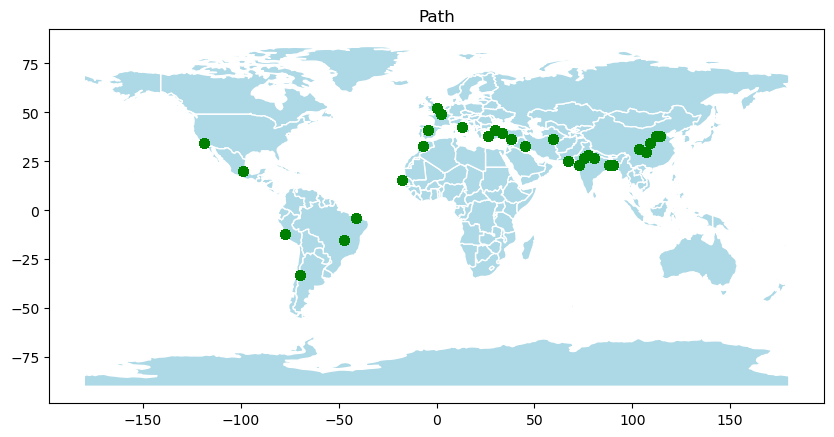

In [86]:
plot_cities_on_map(path, gdf)

In [91]:
#CI SIAMO QUASI


def find_hottest_path(start_city, dest_city, year, gdf):
    # Filter the temperature data for the year of interest
    gdf_year = gdf[gdf['Year'] == year]
    
    # Get the temperature data for the starting city
    start_data = gdf_year[gdf_year['City'] == start_city]
    start_temp = start_data['AvgTemp'].iloc[0]
    
    # Get the geometry of the starting and destination cities
    start_geom = gdf.loc[gdf['City'] == start_city, 'geometry'].iloc[0]
    dest_geom = gdf.loc[gdf['City'] == dest_city, 'geometry'].iloc[0]
    
    # Initialize the nearest cities list
    nearest_cities = []
    
    # Initialize the current city as the starting city
    curr_city = start_city
    
    while curr_city != dest_city:
        # Get the geometry of the current city
        curr_geom = gdf.loc[gdf['City'] == curr_city, 'geometry'].iloc[0]
        print(curr_geom)
        
        # Compute the distance between the current city and all other cities
        gdf['distance'] = gdf.geometry.distance(curr_geom)

        # PROVA MIA 
        if start_geom.x < dest_geom.x:
            # Filter the remaining cities to only include those to the east
            remaining_cities = gdf[gdf['Longitude'] > gdf.loc[gdf['City'] == curr_city, 'Longitude'].iloc[0]]
        else:
            # Filter the remaining cities to only include those to the west
            remaining_cities = gdf[gdf['Longitude'] < gdf.loc[gdf['City'] == curr_city, 'Longitude'].iloc[0]]        
        
        # Sort the remaining cities by distance
        sorted_cities = remaining_cities.sort_values('distance')
        
        # Select the nearest city that has not been selected before
        nearest_city = sorted_cities[~sorted_cities['City'].isin(nearest_cities + [curr_city])].iloc[0]['City']
        
        # Add the nearest city to the list of nearest cities
        nearest_cities.append(nearest_city)
        
        # Update the current city
        curr_city = nearest_city
    
    # Return the list of selected cities
    return nearest_cities

In [97]:
path=find_hottest_path('New York', 'Rome', 1987, gdf)
print(path)

POINT (-74.56 40.99)
POINT (-72.69 45.81)
POINT (-69.3 18.48)
POINT (-40.98 -4.02)
POINT (-38.81 -13.66)
POINT (-17.5 15.27)
POINT (-3.23 5.63)
POINT (3.23 5.63)
POINT (4.05 7.23)
POINT (8.22 12.05)
POINT (15.27 -4.02)
POINT (30.42 -18.48)
POINT (31.38 -29.74)
POINT (39.73 -7.23)
POINT (45.8 2.41)
POINT (46.11 24.92)
POINT (59.67 36.17)
POINT (70.05 34.56)
POINT (73.51 31.35)
POINT (77.27 28.13)
POINT (80.6 26.52)
POINT (88.25 23.31)
POINT (90 23.31)
POINT (95.44 16.87)
POINT (99.91 13.66)
POINT (107.18 10.45)
POINT (112.72 23.31)
POINT (114.46 29.74)
POINT (118.74 31.35)
POINT (120.63 31.35)
POINT (122.36 24.92)
POINT (126.1 37.78)
POINT (136.22 34.56)
POINT (139.23 36.17)
POINT (151.78 -34.56)


IndexError: single positional indexer is out-of-bounds

In [59]:
path = find_hottest_path('Peking', 'Los Angeles', 1850, gdf)
print(path)

POINT (116.53 39.38)
POINT (113.9 37.78)
POINT (111.86 37.78)
POINT (108.97 34.56)
POINT (107.08 29.74)
POINT (103.66 31.35)
POINT (90 23.31)
POINT (88.25 23.31)
POINT (80.6 26.52)
POINT (77.27 28.13)
POINT (75.22 26.52)
POINT (72.52 23.31)
POINT (67.39 24.92)
POINT (59.67 36.17)
POINT (45 32.95)
POINT (37.79 36.17)
POINT (33.29 39.38)
POINT (29.82 40.99)
POINT (26.44 37.78)
POINT (13.09 42.59)
POINT (2.45 49.03)
POINT (0 52.24)
POINT (-4.26 40.99)
POINT (-6.7 32.95)
POINT (-17.5 15.27)
POINT (-40.98 -4.02)
POINT (-47.5 -15.27)
POINT (-69.89 -32.95)
POINT (-77.26 -12.05)
POINT (-98.96 20.09)
['Tangshan', 'Taiyuan', 'Xian', 'Chongqing', 'Chengdu', 'Dhaka', 'Calcutta', 'Kanpur', 'New Delhi', 'Jaipur', 'Ahmadabad', 'Karachi', 'Mashhad', 'Baghdad', 'Aleppo', 'Ankara', 'Istanbul', 'Izmir', 'Rome', 'Paris', 'London', 'Madrid', 'Casablanca', 'Dakar', 'Fortaleza', 'Brasília', 'Santiago', 'Lima', 'Mexico', 'Los Angeles']


In [60]:
def plot_cities_on_map(city_list, gdf):
    # Filter the GeoDataFrame to only include the cities in the city_list
    filtered_gdf = gdf[gdf['City'].isin(city_list)]

    # Plot the cities on a map
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(figsize=(10, 8), edgecolor='white', facecolor='lightblue')
    filtered_gdf.plot(ax=ax, color='green', markersize=40)
   # world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    #ax = world.plot(figsize=(10, 6), edgecolor='black', facecolor='green')
    #filtered_gdf.plot(ax=ax, color='red', markersize=50)

    # Set the title and show the plot
    plt.title('Path')
    plt.show()
    

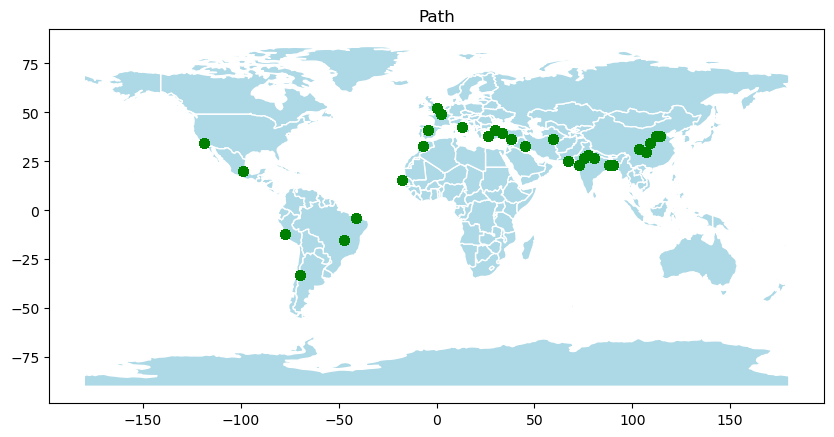

In [61]:
plot_cities_on_map(path, gdf)

In [35]:
# filto il dataset per includere solo gli anni completi (con 12 osservazioni)
filtered_df = count_df[count_df['AvgTemp'] >= 12].reset_index()[['Year', 'City']]
filtered_df

,Year,City
0,1753,Berlin
1,1753,Chicago
2,1753,Istanbul
3,1753,Izmir
4,1753,Kiev
...,...,...
18549,2012,Tokyo
18550,2012,Toronto
18551,2012,Umm Durman
18552,2012,Wuhan


In [37]:
# raggruppo i dati per anno e per città un modo da ottenere la temperatura media annuale 

year_df = new_df.groupby(['Year', 'City']).median(numeric_only=True).reset_index()
year_df

,Year,City,AvgTemp,AvgTempUnc,Latitude,Longitude
0,1753,Berlin,9.5510,3.4015,52.24,13.14
1,1753,Chicago,9.5340,3.0900,42.59,-87.27
2,1753,Istanbul,13.3520,2.8175,40.99,29.82
3,1753,Izmir,16.7985,2.6460,37.78,26.44
4,1753,Kiev,7.9075,2.8980,50.63,31.69
...,...,...,...,...,...,...
18549,2012,Tokyo,13.5385,0.3000,36.17,139.23
18550,2012,Toronto,7.0905,0.2695,44.20,-80.50
18551,2012,Umm Durman,30.5760,1.0550,15.27,32.50
18552,2012,Wuhan,18.8405,0.3960,29.74,114.46


In [38]:
# unisco il dataset a quello originale per mantenere solo gli anni completi 
new_df = pd.merge(year_df, filtered_df, on=['Year', 'City'])


new_df

,Year,City,AvgTemp,AvgTempUnc,Latitude,Longitude
0,1753,Berlin,9.5510,3.4015,52.24,13.14
1,1753,Chicago,9.5340,3.0900,42.59,-87.27
2,1753,Istanbul,13.3520,2.8175,40.99,29.82
3,1753,Izmir,16.7985,2.6460,37.78,26.44
4,1753,Kiev,7.9075,2.8980,50.63,31.69
...,...,...,...,...,...,...
18549,2012,Tokyo,13.5385,0.3000,36.17,139.23
18550,2012,Toronto,7.0905,0.2695,44.20,-80.50
18551,2012,Umm Durman,30.5760,1.0550,15.27,32.50
18552,2012,Wuhan,18.8405,0.3960,29.74,114.46


In [39]:
# osservo l'escursione termica di ogni anno rispetto al precedente e al successivo 

year_df['temp_diff_prev'] = year_df.groupby('City')['AvgTemp'].diff()
year_df['temp_diff_next'] = year_df.groupby('City')['AvgTemp'].diff(-1)

In [41]:
# tengo solo le 10 maggiori escursioni osservate in ogni città 

df_excursions = year_df.groupby('City').apply(
    lambda x: x.nlargest(10, ['temp_diff_prev', 'temp_diff_next'])
)

print(df_excursions)

                        Year              City  AvgTemp  AvgTempUnc  Latitude  \
City                                                                            
Abidjan          15954  1987           Abidjan  27.3825      0.4850      5.63   
                 5012   1877           Abidjan  26.0275      0.9645      5.63   
                 11254  1940           Abidjan  26.8230      0.3170      5.63   
                 8654   1914           Abidjan  26.7445      0.7700      5.63   
                 9854   1926           Abidjan  26.8205      0.7105      5.63   
                 5301   1880           Abidjan  26.3245      1.2265      5.63   
                 13854  1966           Abidjan  26.8115      0.2985      5.63   
                 6355   1891           Abidjan  25.6665      0.7740      5.63   
                 3601   1859           Abidjan  26.1695      1.3545      5.63   
                 10554  1933           Abidjan  26.7350      0.8460      5.63   
Addis Abeba      9155   1919

In [15]:
# count the number of excursions per year for the DataFrame
counts = df_excursions['Year'].value_counts()

# get the top 20 years by excursion count
top20 = counts.nlargest(20)

# print the result
print(top20)

KeyError: 'Year'

In [ ]:
# scrivo una funzione che plotta per ogni anno la mappa dei punti nei quali si rilevano le maggiori escursioni termiche 

def plot_excursions_for_year(df, year):
    
    df_selection_year = df[df['Year'] == year]
    gdf2 = gpd.GeoDataFrame(df_selection_year, geometry=gpd.points_from_xy(df_selection_year['Longitude'], 
                                                                           df_selection_year['Latitude']))

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(figsize=(10, 8), edgecolor='white', facecolor='lightblue')
    gdf2.plot(ax=ax, color='green', markersize=40)
  
    plt.title(f'Excursions locations for year {year}')
    plt.show()


In [ ]:
plot_excursions_for_year(df_excursions, 1905)

In [ ]:


# filto il dataset per includere solo gli anni completi (con 12 osservazioni)
filtered_df = count_df[count_df['AvgTemp'] >= 12].reset_index()[['Year', 'City']]

# unisco il dataset a quello originale per mantenere solo gli anni completi 
new_df = pd.merge(df, filtered_df, on=['Year', 'City'])


new_df

In [28]:
# osservo quante città sono contemplate dal dataset per ogni anno, poiché variano nel tempo

grouped_year = new_df.groupby(new_df.Date)['City'].nunique()
pd.set_option('display.max_rows', 3200)
print(grouped_year)

Date
1753-01-01     14
1753-02-01     14
1753-03-01     14
1753-04-01     14
1753-05-01     14
1753-06-01     14
1753-07-01     14
1753-08-01     14
1753-09-01     14
1753-10-01     14
1753-11-01     14
1753-12-01     14
1754-01-01     10
1754-02-01     10
1754-03-01     10
1754-04-01     10
1754-05-01     10
1754-06-01     10
1754-07-01     10
1754-08-01     10
1754-09-01     10
1754-10-01     10
1754-11-01     10
1754-12-01     10
1755-01-01     10
1755-02-01     10
1755-03-01     10
1755-04-01     10
1755-05-01     10
1755-06-01     10
1755-07-01     10
1755-08-01     10
1755-09-01     10
1755-10-01     10
1755-11-01     10
1755-12-01     10
1756-01-01     11
1756-02-01     11
1756-03-01     11
1756-04-01     11
1756-05-01     11
1756-06-01     11
1756-07-01     11
1756-08-01     11
1756-09-01     11
1756-10-01     11
1756-11-01     11
1756-12-01     11
1757-01-01     11
1757-02-01     11
1757-03-01     11
1757-04-01     11
1757-05-01     11
1757-06-01     11
1757-07-01     11
1757-

In [16]:
# raggruppo i dati per anno e per città un modo da ottenere la temperatura media annuale 

year_df = new_df.groupby(['Year', 'City']).median(numeric_only=True).reset_index()
year_df

,Year,City,AvgTemp,AvgTempUnc,Latitude,Longitude
0,1753,Berlin,9.5510,3.4015,52.24,13.14
1,1753,Chicago,9.5340,3.0900,42.59,-87.27
2,1753,Istanbul,13.3520,2.8175,40.99,29.82
3,1753,Izmir,16.7985,2.6460,37.78,26.44
4,1753,Kiev,7.9075,2.8980,50.63,31.69
...,...,...,...,...,...,...
18549,2012,Tokyo,13.5385,0.3000,36.17,139.23
18550,2012,Toronto,7.0905,0.2695,44.20,-80.50
18551,2012,Umm Durman,30.5760,1.0550,15.27,32.50
18552,2012,Wuhan,18.8405,0.3960,29.74,114.46


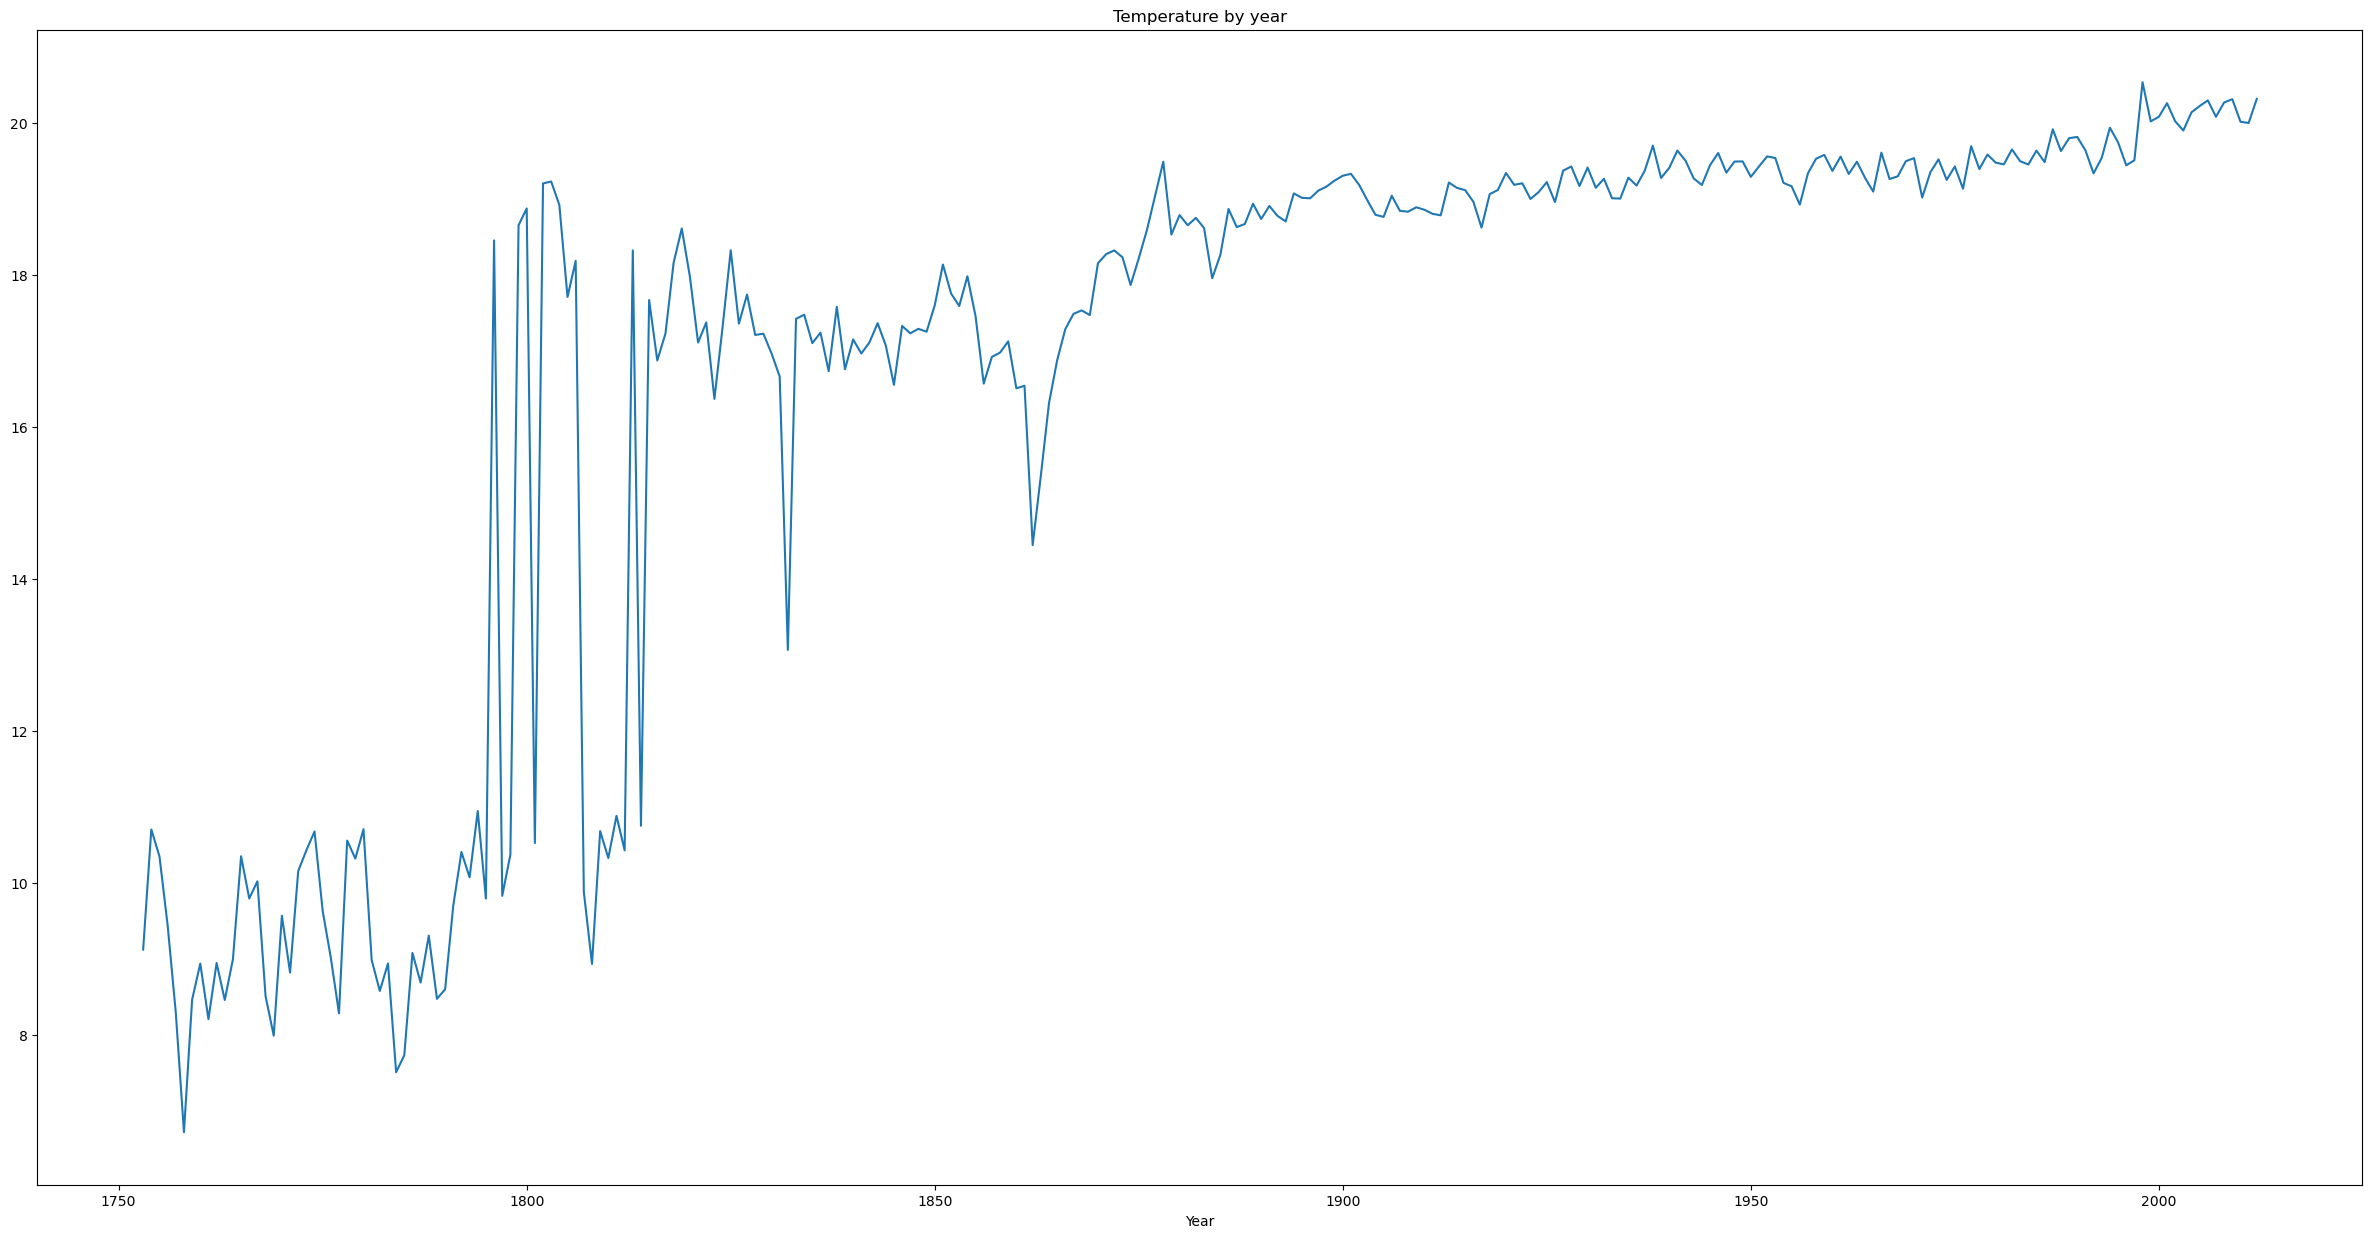

In [18]:
year_df.groupby(year_df.Year)['AvgTemp'].mean().plot(figsize=(30,15), title="Temperature by year")
plt.show()

In [31]:
# escludo i valori dove ci sono anni precedenti o successivi null
valid_rows = year_df['AvgTemp'].notnull() & year_df['AvgTemp'].shift().notnull() & year_df['AvgTemp'].shift(-1).notnull()
year_df = year_df[valid_rows]

# tengo solo le 200 maggiori escursioni rilevate
df_excursions = year_df.sort_values(['temp_diff_prev', 'temp_diff_next'], ascending=False).head(200)

print(df_excursions)

       Year              City  AvgTemp  AvgTempUnc  Latitude  Longitude  \
13902  1966              Kiev  11.0825      0.3065     50.63      31.69   
11425  1941          New York  12.5250      0.2325     40.99     -74.56   
2214   1839           Toronto   7.7980      1.6055     44.20     -80.50   
3206   1853  Saint Petersburg   3.7940      1.1825     60.27      29.19   
18459  2012            Ankara  13.9040      0.4180     39.38      33.29   
...     ...               ...      ...         ...       ...        ...   
8075   1908           Chicago   9.6640      0.3620     42.59     -87.27   
17101  1998           Karachi  29.4860      0.3665     24.92      67.39   
340    1779            London  10.6385      4.1055     52.24      -0.00   
10839  1935          Shenyang  10.0465      0.4290     40.99     123.55   
11150  1938           Toronto   7.8430      0.2440     44.20     -80.50   

       temp_diff_prev  temp_diff_next  
13902          5.6875          0.9195  
11425          4.98

In [38]:
# tengo solo le 10 maggiori escursioni osservate in ogni città 

df_excursions = year_df.groupby('City').apply(
    lambda x: x.nlargest(10, ['temp_diff_prev', 'temp_diff_next'])
)

print(df_excursions)

               Year     City  AvgTemp  AvgTempUnc  Latitude  Longitude  \
City                                                                     
Abidjan 15954  1987  Abidjan  27.3825      0.4850      5.63      -3.23   
        5012   1877  Abidjan  26.0275      0.9645      5.63      -3.23   
        11254  1940  Abidjan  26.8230      0.3170      5.63      -3.23   
        8654   1914  Abidjan  26.7445      0.7700      5.63      -3.23   
        9854   1926  Abidjan  26.8205      0.7105      5.63      -3.23   
...             ...      ...      ...         ...       ...        ...   
Xian    15053  1977     Xian  13.5980      0.3130     34.56     108.97   
        7953   1906     Xian  11.4720      1.0800     34.56     108.97   
        17753  2004     Xian  13.5855      0.2900     34.56     108.97   
        16053  1987     Xian  13.2805      0.3215     34.56     108.97   
        5011   1876     Xian  12.5790      1.5565     34.56     108.97   

               temp_diff_prev  temp_d

In [39]:

# count the number of excursions per year for the DataFrame
counts = df_excursions['Year'].value_counts()

# get the top 20 years by excursion count
top20 = counts.nlargest(20)

# print the result
print(top20)

1998    40
1987    29
1977    23
1877    22
1941    22
1876    18
1935    18
2011    16
1972    16
1905    16
1927    16
1938    14
1918    14
1951    13
1899    13
1878    12
1858    12
1966    12
2012    12
1994    12
Name: Year, dtype: int64


In [33]:
# scrivo una funzione che plotta per ogni anno la mappa dei punti nei quali si rilevano le maggiori escursioni termiche 

def plot_excursions_for_year(df, year):
    
    df_selection_year = df[df['Year'] == year]
    gdf2 = gpd.GeoDataFrame(df_selection_year, geometry=gpd.points_from_xy(df_selection_year['Longitude'], 
                                                                           df_selection_year['Latitude']))

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(figsize=(10, 8), edgecolor='white', facecolor='lightblue')
    gdf2.plot(ax=ax, color='green', markersize=40)
  
    plt.title(f'Excursions locations for year {year}')
    plt.show()


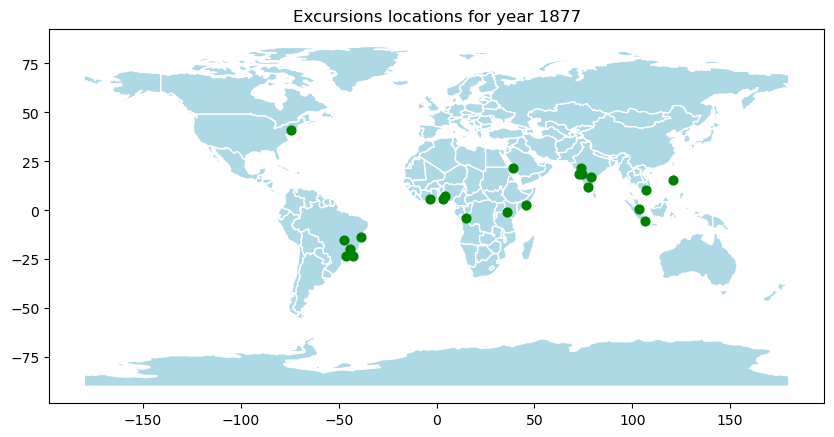

In [43]:
plot_excursions_for_year(df_excursions, 1877)

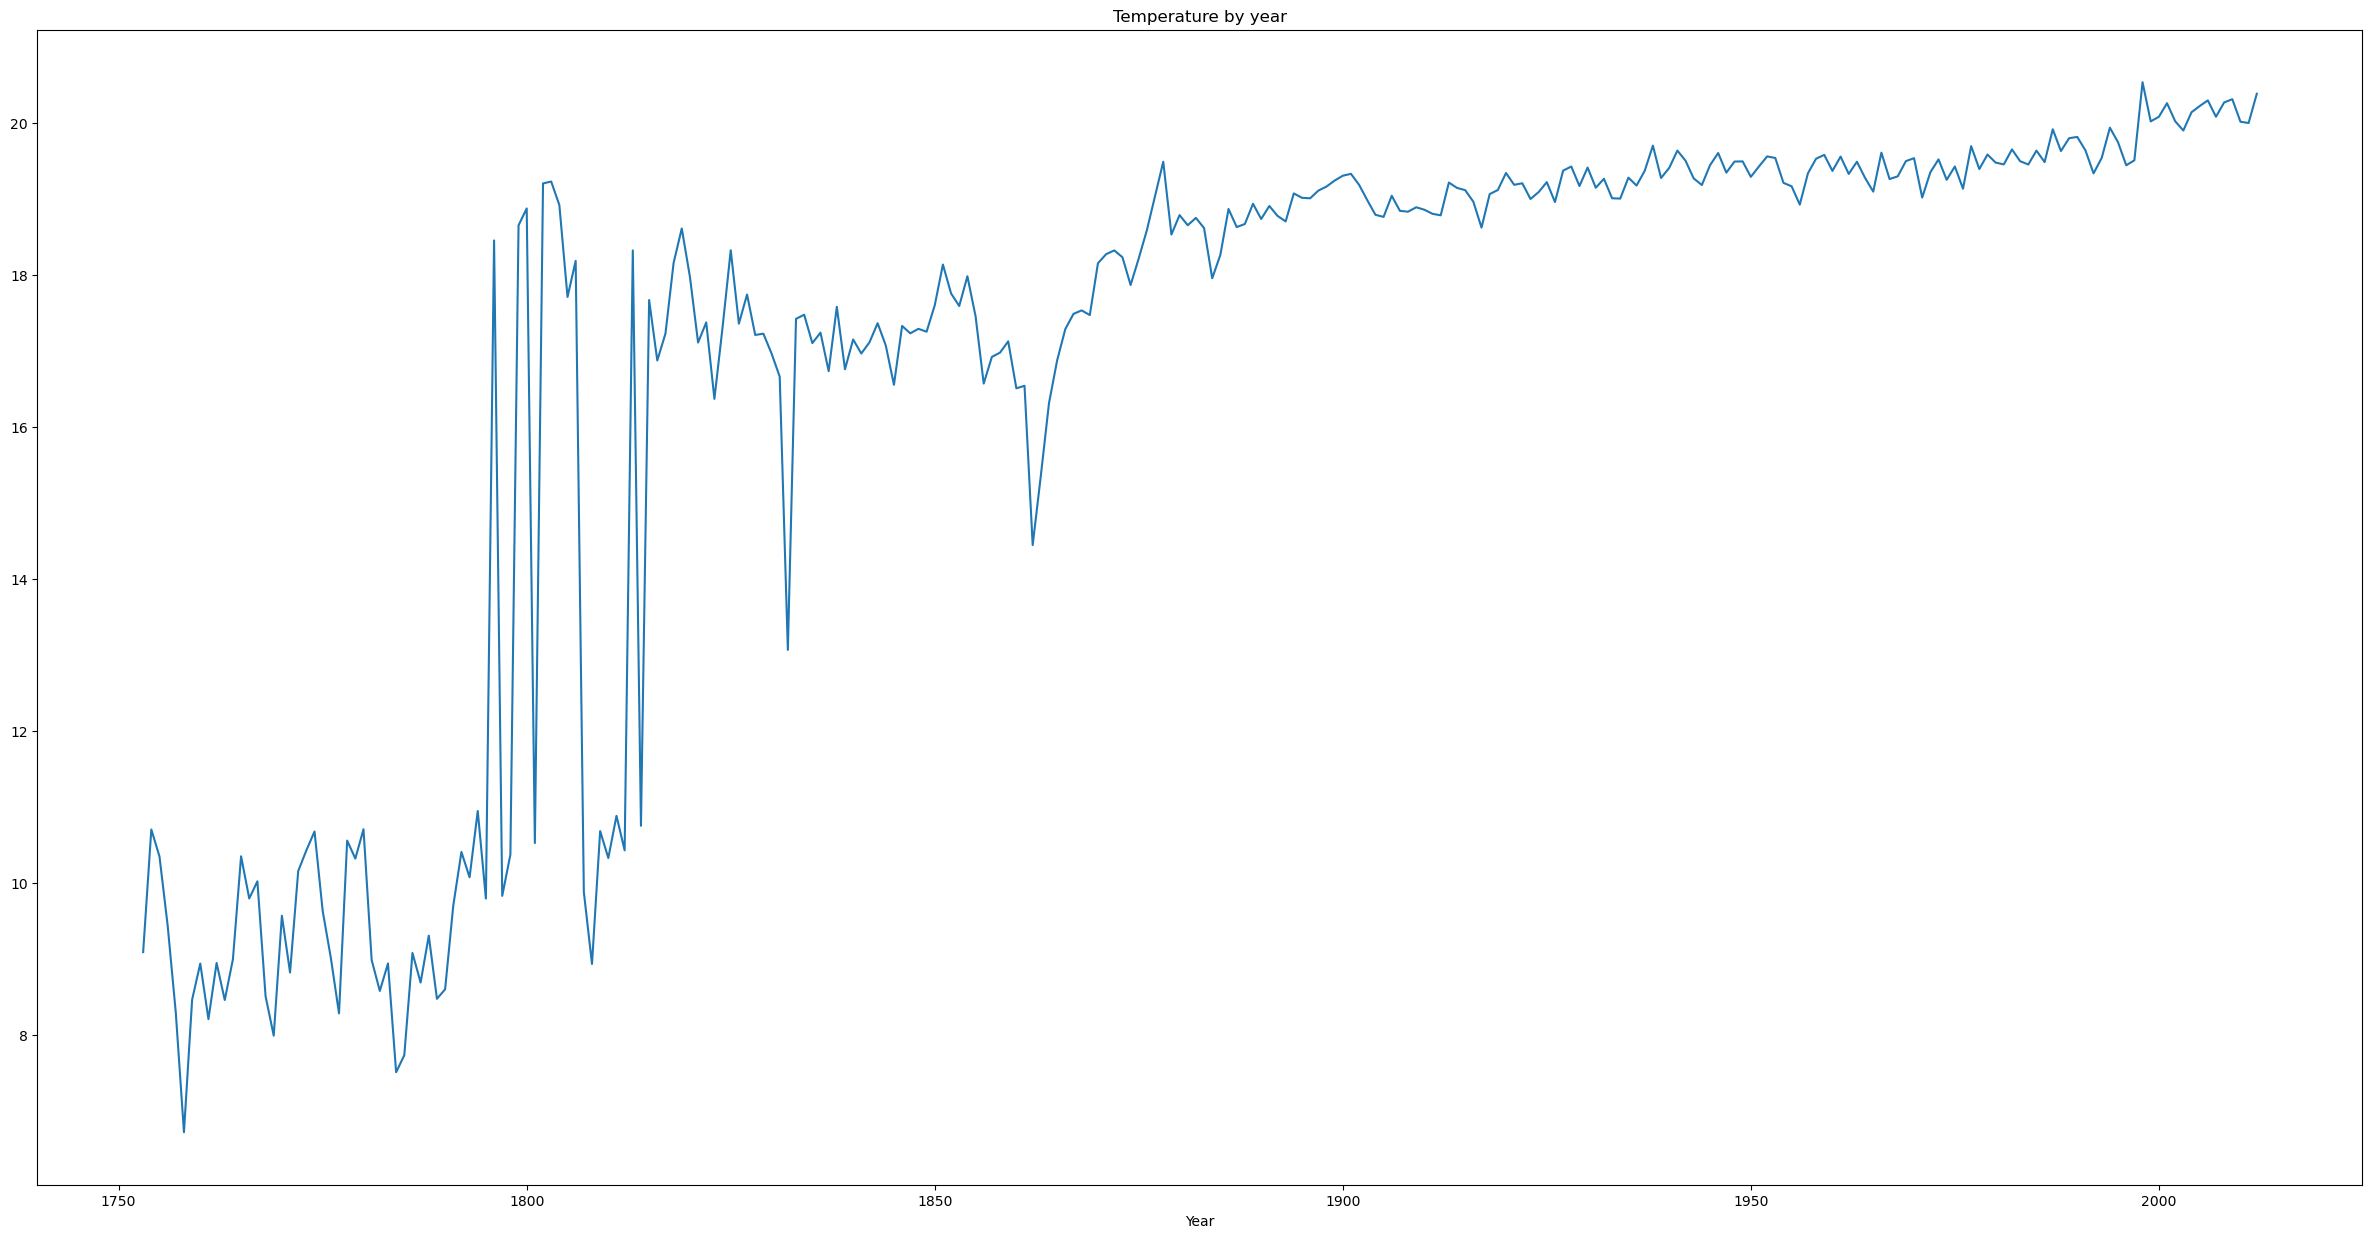

In [45]:
year_df.groupby(year_df.Year)['AvgTemp'].mean().plot(figsize=(30,15), title="Temperature by year")
plt.show()